In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hexstorypoints/Hexaview1.csv
/kaggle/input/hexstorypoints/RapidX.csv
/kaggle/input/hexstorypoints/Augmented_Storypointsdata (1).csv
/kaggle/input/hexstorypoints/Hexaview2.csv
/kaggle/input/hexstorypoints/ATOP.csv
/kaggle/input/hexstorypoints/ATOP - JUMBO.csv
/kaggle/input/hexstorypoints/Test-SP (1).csv
/kaggle/input/hexstorypoints/Coco.csv
/kaggle/input/hexstorypoints/Tensai.csv


Notebook ref1. : https://colab.research.google.com/drive/1G_4o-1_CkR4eNgzGVcx89IJ_lKLBQQv-?usp=sharing#scrollTo=qA7WQaz0q0H7

ref2. : https://towardsdatascience.com/use-active-learning-to-boost-your-ml-problem-53c70f72b979#4bc0

In [2]:
# do all the needed imports
import pandas as pd
import json
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [24]:
# Augmented data
merged_aug = pd.read_csv('../input/hexstorypoints/Augmented_Storypointsdata (1).csv', index_col=0)
stp_test = pd.read_csv('../input/hexstorypoints/Test-SP (1).csv', index_col=0)

In [77]:
atop_j = pd.read_csv('../input/hexstorypoints/ATOP - JUMBO.csv')
atop = pd.read_csv('../input/hexstorypoints/ATOP.csv')
coco = pd.read_csv('../input/hexstorypoints/Coco.csv')
hexaview1 = pd.read_csv('../input/hexstorypoints/Hexaview1.csv')
hexaview2 = pd.read_csv('../input/hexstorypoints/Hexaview2.csv')
rapidx = pd.read_csv('../input/hexstorypoints/RapidX.csv')
tensai = pd.read_csv('../input/hexstorypoints/Tensai.csv')

In [78]:
merged_data = pd.concat([atop_j,atop,coco,hexaview1,hexaview2,rapidx,tensai],axis=0)

In [79]:
Sdf = merged_data[~merged_data['Story Points'].isna()]
non_sdf = merged_data[merged_data['Story Points'].isna()]

In [80]:
Sdf = Sdf[['Work Item Type','Title','Title 1','Title 2','Title 3','Title 4','Title 5','Description','Story Points']].fillna('')
non_sdf = non_sdf[['Work Item Type','Title','Title 1','Title 2','Title 3','Title 4','Title 5','Description','Story Points']].fillna('')

In [121]:
non_sdf.shape

(4527, 11)

In [81]:
import re
def clean_email(text):
    pattern= re.compile(r'mail message from:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'sent:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'file path:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'contact information:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'fw:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r're:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'from:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'to:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'cc:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'email:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'subject:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'\S*@\S*\s?')
    text = pattern.sub(r' ', text)
    
    return text


def remove_html_tags(html_text):
    pattern = re.compile(r'<.*?>') #(.*?)<.*?>
    html_text = pattern.sub(' ', html_text)
    pattern = re.compile(r'&nbsp')
    html_text = pattern.sub('',html_text)
    pattern = re.compile(r'https?:\/\/.*[\r\n]*')
    html_text = pattern.sub('',html_text)
    return html_text


def remove_common(text):
    pattern= re.compile(r'date:(.*?)\\r\\n')
    text = pattern.sub(r' ', text)
    pattern= re.compile(r'[0-9][\-0–90-9 ]+') # phone
    text = pattern.sub(r' ', text)
    pattern= re.compile(r'\d+') # alphanumeric
    text = pattern.sub(r' ', text)
    pattern= re.compile(r'[^a-zA-z]+')
    text = pattern.sub(r' ', text)
#     pattern= re.compile(r'\W*\b\w{1,2}\b') # single letter
#     text = pattern.sub(r' ', text)
    return text
    

def remove_trailing(text):
    trailing_space = re.compile(r'\\t|\\n|\\r|\t|\n|\r')
    text = trailing_space.sub(r' ', text)   
    return text

def remove_extra_white_space(text):
    trailing_space = re.compile(r'\s\s+')
    text = trailing_space.sub(r' ', text)
    return text
    
    

def cleaning_process(text):
    text = text.lower()
    cleaned_email = clean_email(text)
    cleaned_tags = remove_html_tags(cleaned_email)
    remove_common_text = remove_common(cleaned_tags)
    remove_trailing_text = remove_trailing(remove_common_text)
    final_text = remove_extra_white_space(remove_trailing_text)
    return final_text

In [82]:
Sdf[['Title','Title 1','Title 2','Title 3','Title 4','Title 5','Description']].astype("string")
non_sdf[['Title','Title 1','Title 2','Title 3','Title 4','Title 5','Description']].astype("string")

,Title,Title 1,Title 2,Title 3,Title 4,Title 5,Description
0,,Test,,,,,
1,,Ability to copy the rules and filters from one...,,,,,<div>Ability to copy the rules and filters fro...
2,,Primary key needs to be auto populated in the ...,,,,,
3,,Integration with JIRA for automatic creation o...,,,,,
4,,"Fetching PK of a table incase there is no PK, ...",,,,,
...,...,...,...,...,...,...,...
1715,,"Tooltip name should be changed from ""Edit Tab""...",,,,,
1716,,"Codebase optimization - ServiceNow, ELK, ATOP ...",,,,,
1717,,Making WidgetMapSpec DB driven.,,,,,
1718,,Last 6 months data line is not being visible w...,,,,,


In [83]:
Sdf['Composite_Desc'] =  Sdf['Title'] + ' ' + Sdf['Title 1'] + ' '+  Sdf['Title 2'] + ' ' + Sdf['Title 3'] + ' ' +Sdf['Title 4'] + ' ' +Sdf['Title 5'] + ' ' +Sdf['Description']
non_sdf['Composite_Desc'] =  non_sdf['Title'] + ' ' + non_sdf['Title 1'] + ' '+  non_sdf['Title 2'] + ' ' + non_sdf['Title 3'] + ' ' +non_sdf['Title 4'] + ' ' +non_sdf['Title 5'] + ' ' +non_sdf['Description']

In [84]:
Sdf['Cleaned_desc'] = Sdf['Composite_Desc'].apply(cleaning_process)
non_sdf['Cleaned_desc'] = non_sdf['Composite_Desc'].apply(cleaning_process)

,Work Item Type,Title,Title 1,Title 2,Title 3,Title 4,Title 5,Description,Story Points,Composite_Desc,Cleaned_desc
0,User Story,,Test,,,,,,,Test,test
1,User Story,,Ability to copy the rules and filters from one...,,,,,<div>Ability to copy the rules and filters fro...,,Ability to copy the rules and filters from on...,ability to copy the rules and filters from on...
2,User Story,,Primary key needs to be auto populated in the ...,,,,,,,Primary key needs to be auto populated in the...,primary key needs to be auto populated in the...
3,User Story,,Integration with JIRA for automatic creation o...,,,,,,,Integration with JIRA for automatic creation ...,integration with jira for automatic creation ...
4,User Story,,"Fetching PK of a table incase there is no PK, ...",,,,,,,"Fetching PK of a table incase there is no PK,...",fetching pk of a table incase there is no pk ...
...,...,...,...,...,...,...,...,...,...,...,...
1715,Bug,,"Tooltip name should be changed from ""Edit Tab""...",,,,,,,"Tooltip name should be changed from ""Edit Tab...",tooltip name should be changed from edit tab ...
1716,Task,,"Codebase optimization - ServiceNow, ELK, ATOP ...",,,,,,,"Codebase optimization - ServiceNow, ELK, ATOP...",codebase optimization servicenow elk atop clo...
1717,Task,,Making WidgetMapSpec DB driven.,,,,,,,Making WidgetMapSpec DB driven.,making widgetmapspec db driven
1718,Bug,,Last 6 months data line is not being visible w...,,,,,,,Last 6 months data line is not being visible ...,last months data line is not being visible wh...


In [86]:
Sdf['Story Points'] = Sdf['Story Points'].astype(int)
# non_sdf['Story Points'] = non_sdf['Story Points'].astype(int)

In [87]:
df3=pd.DataFrame()
df3['Y']= merged_aug['Story Points']
df3['X']=merged_aug['Cleaned_desc']

In [88]:
df4=pd.DataFrame()
df4['Y']= non_sdf['Story Points']
df4['X']=non_sdf['Cleaned_desc']

In [127]:
# df3.value_counts()

In [93]:
merged_data = df3.loc[df3['Y'].isin([2,3,5,1,8])]

In [98]:
# merged_data

In [99]:
df4.shape

(4527, 2)

In [116]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

merged_data['encoded_labels'] = le.fit_transform(merged_data['Y'])
df4['encoded_labels'] = le.fit_transform(df4['Y'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [104]:
# split data into train and test
train, test = train_test_split(merged_data, test_size=0.2, random_state=42)
# let's select some sample from train set 
initial_train = train.sample(frac=0.05, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
# and create our unlabelled pool
# pool = train[~train.index.isin(initial_train.index)]
# pool.reset_index(drop=True, inplace=True)

pool = df4
pool.reset_index(drop=True, inplace=True)

In [128]:
initial_train

,Y,X,encoded_labels
0,5,uc 15 testing - the optimal ui tests to be se...,3
1,5,excel upload connector changes the following p...,3
2,2,org_admin default user in atop get emailid and...,1
3,5,buildquality connector issue,3
4,5,poc on filter implementation,3
...,...,...,...
56,8,hp alm angular conversion converting the follo...,4
57,3,ml repo api jwt token implementation to implem...,2
58,5,hexaview angular conversion to latest version ...,3
59,5,secure the postgraphile service with azure api...,3


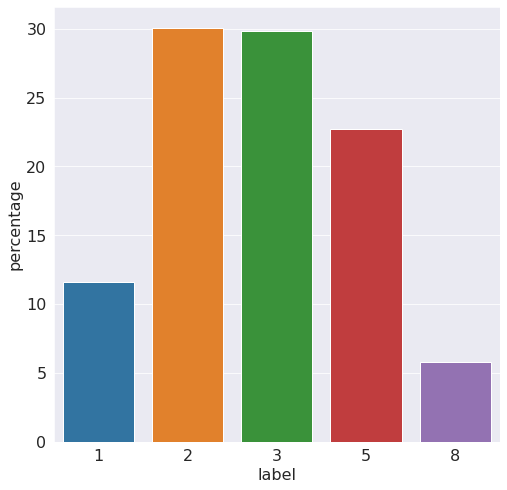

In [106]:
label_counts = (merged_data['Y']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )
BIGGER_SIZE: int = 16
plt.figure(figsize=(8,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
sns.set_style("darkgrid")
p = sns.barplot(x="label", y="percentage", data=label_counts)

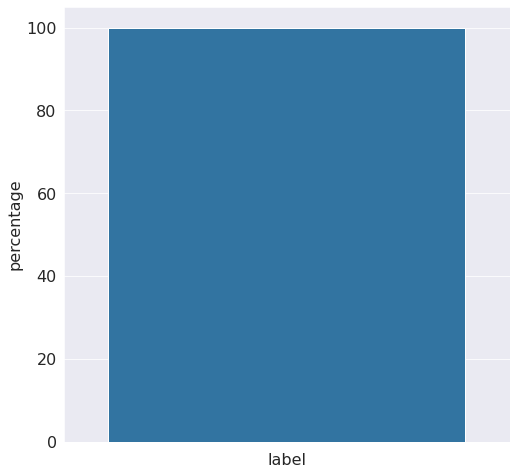

In [118]:
label_counts = (df4['Y']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )
BIGGER_SIZE: int = 16
plt.figure(figsize=(8,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
sns.set_style("darkgrid")
p = sns.barplot(x="label", y="percentage", data=label_counts)

In [109]:
class QueryStrategy(abc.ABC):
    @abc.abstractmethod
    def selection(self, *args, **kwargs):
        raise NotImplementedError

In [110]:
class RandomSelection(QueryStrategy):
    """
    Random selection strategy.

    Parameters:
    probs: int - number of data samples in unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int) -> List[int]:
        if probs.shape[0] >= num_samples:
            selection = np.random.choice(probs.shape[0], num_samples, replace=False)
        else:
            selection = np.arange(probs.shape[0])
        return selection

In [112]:
class MarginSelection(QueryStrategy):
    """
    Margin selection strategy.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples:int) -> List[int]:
        rev = np.sort(probs, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        if len(probs) >= num_samples:
            selection = np.argsort(values)[:num_samples]
        else:
            selection = np.argsort(values)
        return selection

In [12]:
class MostErrorBucketSelection(QueryStrategy):
    """
    Select from the specific range of the predicted probabilities, which contains the most amount of errors.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select
    train: pd.Dataframe - train
    clf - classificator

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int, train_: pd.DataFrame, clf):
        train_["probs"] = clf.predict_proba(train_["X"])[:, 1]
        train_["decile"] = pd.cut(train_["probs"], 10)
        train_["preds"] = clf.predict(train_["X"])
        train_["error"] = train_.apply(lambda x: 1 if x["preds"] != x["encoded_labels"] else 0, axis=1)
        train_["num_errors"] = train_.groupby("decile")["error"].transform(lambda x: x.sum())
        error_inter = train_.iloc[train_["num_errors"].argmax()]["decile"]
        mask = np.array([True if a in error_inter else False for a in probs[:, 1]])
        selection = mask.argsort()[-num_samples:]
        return selection

In [113]:
class EmbeddingSimilatitySelection(QueryStrategy):
    """
    Select from the samples which similar to particular class examples in already labelled data with deep embeddings.

    Parameters:
    embedder: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select
    trn: pd.Dataframe - train dataset
    pl: pd.Dataframe - pool of unlabelled data

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, embedder, num_samples: int, train_: pd.DataFrame, pool_: pd.DataFrame):
        matrix1 = embedder(train_.query["X"].values).numpy()
        matrix2 = embedder(pool_["X"].values).numpy()
        res = 1 - sp.distance.cdist(matrix1, matrix2, 'cosine')
        col_max = np.amax(res, axis=0)
        selected_indices = np.argsort(col_max)[-num_samples:]
        return selected_indices

In [119]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 10):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["X"], self.train["encoded_labels"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(f1_score(self.test["encoded_labels"],
                                                self.classifier.predict(self.test["X"]),
                                                average='micro'))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["X"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["X"], self.train["encoded_labels"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["X"]) # do the predictions on the test set
            self.calculated_metrics.append(f1_score(self.test["encoded_labels"], preds,average='micro')) # monitor choosen metric on test set

In [17]:
# test

In [18]:
# initial_train

In [19]:
# pool

In [20]:
# classifier

In [120]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/10)
# specify the classifier
classifier = Pipeline([
                ('tfidf', TfidfVectorizer(
                                          min_df=3,
                                          max_features=None,
                                          strip_accents='unicode',
                                          analyzer='word',
                                          ngram_range=(1, 2),
                                          use_idf=1,
                                          smooth_idf=1,
                                          sublinear_tf=1
                                          )),
#                   ('svd',TruncatedSVD(n_components=500)),
                ('clf', LogisticRegression(multi_class='multinomial', solver = 'newton-cg')),
               ])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# # margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = MarginSelection())

# # most error in the bucket selection
error_bucket_cycle = ActiveLearner(test, initial_train, pool, classifier)
error_bucket_cycle.active_learning_cycle(iterations_num = iterations_num,
                                         selection_type = MostErrorBucketSelection())

# # text similarity selection
# embedder_cycle = ActiveLearner(test, initial_train, pool, classifier)
# embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embedder_cycle.active_learning_cycle(iterations_num = iterations_num,
#                                      selection_type = EmbeddingSimilatitySelection(),
#                                      embedder=embedder)

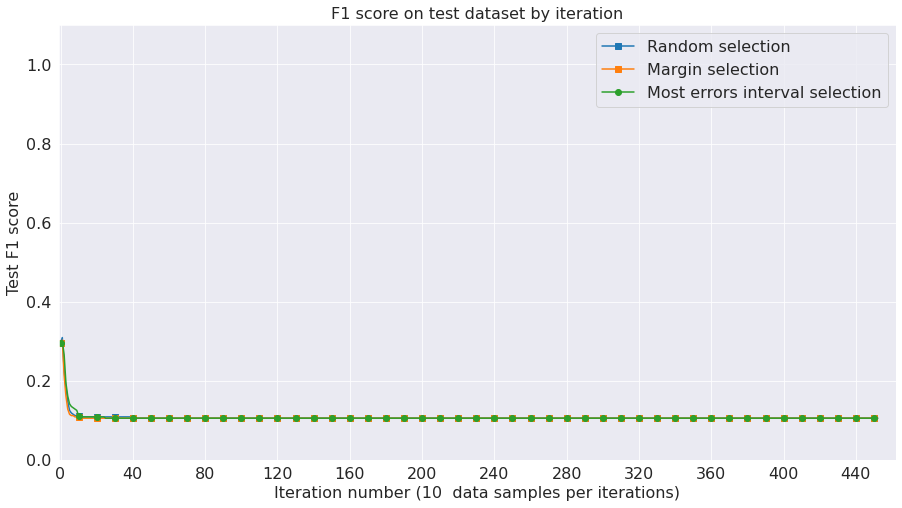

In [122]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration number (10  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=10)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=10)
plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
# plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query

In [130]:
df4

,Y,X,encoded_labels
0,,test,0
1,,ability to copy the rules and filters from on...,0
2,,primary key needs to be auto populated in the...,0
3,,integration with jira for automatic creation ...,0
4,,fetching pk of a table incase there is no pk ...,0
...,...,...,...
4522,,tooltip name should be changed from edit tab ...,0
4523,,codebase optimization servicenow elk atop clo...,0
4524,,making widgetmapspec db driven,0
4525,,last months data line is not being visible wh...,0
